# Step-by-step demonstration of Kolmogorov–Smirnov tests  
*(one-sample and two-sample)*

This notebook-style demonstration illustrates the practical implementation and interpretation of the Kolmogorov–Smirnov (KS) test. It generates synthetic data, computes KS statistics and corresponding *p*-values, visualizes empirical distribution functions (CDFs), and explains each step in a transparent and reproducible manner.

---

## Overview

The demonstration covers:

- **One-sample KS test**: comparing a sample distribution to a specified theoretical distribution.
- **Two-sample KS test**: comparing two independent samples to assess whether they arise from the same distribution.

Both cases emphasize interpretation of the test statistic, the role of the empirical CDFs, and the decision-making process.

---

## Methodological Notes

### Definition of the KS Statistic

- **One-sample KS test**  
  $$
  D = \sup_x \left| F_n(x) - F_0(x) \right|
  $$
  where $F_n(x)$ is the empirical CDF of the sample and $F_0(x)$ is the hypothesized theoretical CDF.

- **Two-sample KS test**  
  $$D = \sup_x \left| F_{n_1}(x) - F_{n_2}(x) \right|$$
  where $F_{n_1}(x)$ and $F_{n_2}(x)$ are the empirical CDFs of the two independent samples.

---

### Computation of *p*-values

- When available, the implementation relies on  
  `scipy.stats.kstest` (one-sample) and  
  `scipy.stats.ks_2samp` (two-sample), which provide accurate *p*-values based on established asymptotic distributions.

- If SciPy is unavailable, *p*-values are approximated using the classical Kolmogorov distribution series:
  $$
  P(D_n \le d) \approx 1 - 2 \sum_{j=1}^{\infty} (-1)^{j-1}
  \exp\!\left(-2 j^2 d^2 n\right),
  $$
  leading to the approximation
  $$
  p\text{-value} \approx
  2 \sum_{j=1}^{\infty} (-1)^{j-1}
  \exp\!\left(-2 j^2 d^2 n\right)
  $$
  for the one-sample test.

- For the two-sample test, the effective sample size
  $$
  n_{\text{eff}} = \frac{n_1 n_2}{n_1 + n_2}
  $$
  replaces $n$ in the series approximation.

---

## Demonstration Structure

The script produces the following analyses:

1. **One-sample KS test**
   - Sample drawn from $ \mathcal{N}(0,1) $, compared against $ \mathcal{N}(0,1) $
   - Sample drawn from an $\exp(1)$ distribution, compared against $ \mathcal{N}(0,1) $

2. **Two-sample KS test**
   - Comparison of two independent samples: one normal and one exponential

---

## Visualization

For each test, the following plots are produced:

- Empirical CDF(s) of the sample(s)
- Theoretical CDF (for one-sample tests)
- A graphical indication of the point at which the maximum absolute difference (the KS statistic) occurs

These visualizations reinforce the interpretation of the KS statistic as the maximum vertical separation between distribution functions.


Here we define some utility functions we will be using.

**Important: Set USE_SCIPY = False to use our implementation of the test.**

**To use scipy implementation, change it to True**.

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt, exp
import warnings

from scipy import stats

# Set this parameter to True to use the scipy implementataion of the test.
# Set this parameter to False to use the our implementation (by hand).
USE_SCIPY = False

# Utility: Calculate ECDF for a given sample.
def empirical_cdf(sample, x_values):
    """Compute empirical CDF values for x_values given sample (1D array)."""
    sample = np.asarray(sample)
    n = sample.size
    # For each x, proportion of sample <= x
    return np.searchsorted(np.sort(sample), x_values, side='right') / n

# Compute KS statistics for one-sample.
def ks_statistic_onesample(sample, cdf_func):
    """Compute KS statistic D for one-sample test against CDF function cdf_func(x)."""
    sample = np.sort(np.asarray(sample))
    n = sample.size
    # Evaluate differences at sample points (two sided): sup |F_n(x) - F(x)|
    # Use both left and right empirical CDF values at each sample point
    cdf_vals = cdf_func(sample)
    ecdf_right = np.arange(1, n+1) / n   # F_n(x) at sample value using right-continuity
    ecdf_left  = np.arange(0, n)   / n   # F_n(x-) just before each sample value
    d_plus  = np.max(ecdf_right - cdf_vals)
    d_minus = np.max(cdf_vals - ecdf_left)
    D = max(d_plus, d_minus)
    return D

# Compute KS statistics for one-sample and two-sample.
def ks_statistic_twosample(sample1, sample2):
    """Compute two-sample KS statistic D = sup |F_n1 - F_n2| and the x at which it occurs."""
    x_all = np.sort(np.concatenate((sample1, sample2)))
    F1 = empirical_cdf(sample1, x_all)
    F2 = empirical_cdf(sample2, x_all)
    diffs = np.abs(F1 - F2)
    idx = np.argmax(diffs)
    return diffs[idx], x_all[idx], F1[idx], F2[idx]

# Kolmogorov distribution series for asymptotic p-value.
def kolmogorov_pvalue_onesample(D, n, terms=1000):
    """Approximate two-sided p-value for one-sample KS test using series:
       p ≈ 2 * sum (-1)^(i-1) * exp(-2*i^2*D^2*n).
       We truncate after 'terms' terms (stop earlier if terms small)."""
    if D <= 0:
        return 1.0
    s = 0.0
    for j in range(1, terms+1):
        term = (-1)**(j-1) * np.exp(-2 * (j**2) * (D**2) * n)
        s += term
        # stop early if term tiny
        if abs(term) < 1e-12:
            break
    p = 2.0 * s
    # ensure valid bounds
    if p < 0:
        p = 0.0
    if p > 1:
        p = 1.0
    return p

# Calculate the p-value of K-S test in two-sample case.
def kolmogorov_pvalue_twosample(D, n1, n2, terms=1000):
    """Approximate two-sample KS p-value using effective sample size n_eff = n1*n2/(n1+n2)."""
    n_eff = n1 * n2 / (n1 + n2)
    return kolmogorov_pvalue_onesample(D, n_eff, terms=terms)

# The theoretical CDF we will compare to: standard normal CDF.
def std_normal_cdf(x):
    return stats.norm.cdf(x)

def get_critical_value(a):
    return stats.kstwobign.ppf(1-a)

def make_test_decision(D_stats, crit_value):
    if abs(D_stats) < crit_value:
        return "Fail to reject H0"
    else:
        return "Reject H0"
    


# SECTION A: ONE-SAMPLE KS TEST
Demonstrate with two cases:

* sample drawn from $\mathcal{N}(0,1)$ -> should not reject $H_0: F = \mathcal{N}(0,1)$
* sample drawn from $\exp(1)$ -> should reject $H_0: F = \mathcal{N}(0,1)$

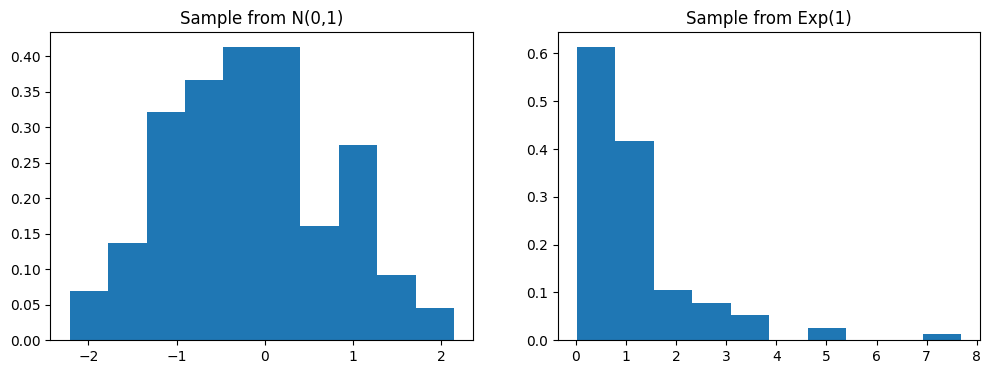

In [86]:
np.random.seed(2025)  # reproducibility
sig_level = 0.05

# generate samples
n = 100
sample_normal = np.random.normal(loc=0.0, scale=1.0, size=n)
sample_exp = np.random.exponential(scale=1.0, size=n)

# Plot the histogram of the samples.
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(sample_normal, density=True)
axes[0].set_title("Sample from N(0,1)")

axes[1].hist(sample_exp, density=True)
axes[1].set_title("Sample from Exp(1)")
plt.show()


## Case 1: Compare with actual distribution.
Ideally, we should *fail* to reject $H_0$.

### Run the test

We use the data sample generated from $\mathcal{N}(0, 1)$
and we test it against the $\mathcal{N}(0, 1)$.

In [87]:
print("=== ONE-SAMPLE KS TEST (comparison to N(0,1)) ===\n")

name = "Normal sample (N(0,1))"
sample = sample_normal
crit_value = get_critical_value(sig_level) / sqrt(n)
print(f"Case: {name} (n={sample.size})")
print(f"Critical value: {crit_value}, Significance Level: {sig_level}")

# compute KS statistic
if USE_SCIPY:
    D, pvalue = stats.kstest(sample, 'norm')
    print(f"SciPy kstest results: D = {D:.5f}, p-value = {pvalue}")
else:
    D = ks_statistic_onesample(sample, std_normal_cdf)
    pvalue = kolmogorov_pvalue_onesample(D, sample.size)
    print(f"Results: D = {D:.5f}, p-value = {pvalue}")

print("_" * 50)
print(make_test_decision(D, crit_value))

=== ONE-SAMPLE KS TEST (comparison to N(0,1)) ===

Case: Normal sample (N(0,1)) (n=100)
Critical value: 0.13580986393225505, Significance Level: 0.05
Results: D = 0.11534, p-value = 0.13976056162460002
__________________________________________________
Fail to reject H0


### Visualize
Plot the ECDF of the sample and actual CDF of the hypotetic distribution.

Also, plot the maximum difference between the two.

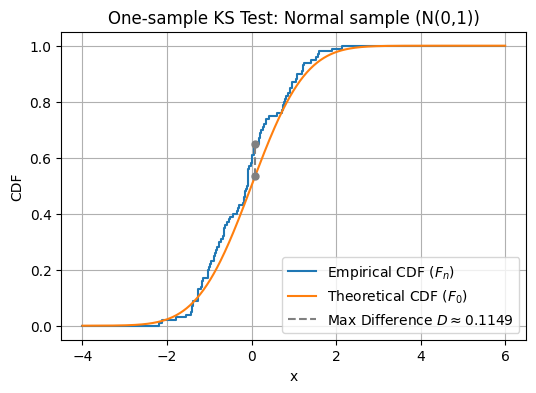

In [88]:
# Plot empirical CDF vs theoretical CDF and indicate D
x_grid = np.linspace(min(sample.min(), -4), max(sample.max(), 6), 500)
ecdf_vals = empirical_cdf(sample, x_grid)
theo_vals = std_normal_cdf(x_grid)

# compute point of maximum difference for plotting (fine grid approx)
grid_diffs = np.abs(ecdf_vals - theo_vals)
idx_max = np.argmax(grid_diffs)
x_max = x_grid[idx_max]
D_plot = grid_diffs[idx_max]

plt.figure(figsize=(6,4))

# Plot ECDF and Theoretical CDF
plt.step(x_grid, ecdf_vals, where='post', label='Empirical CDF ($F_n$)')
plt.plot(x_grid, theo_vals, label='Theoretical CDF ($F_0$)')

plt.vlines(x_max, theo_vals[idx_max], ecdf_vals[idx_max],
            color='gray', # Use a distinct color
            linestyles='dashed',
            zorder=5,
            label=f"Max Difference $D \\approx {D_plot:.4f}$") # Use zorder to ensure it's on top

plt.plot(x_max, theo_vals[idx_max], 'o', color='gray', markersize=5, zorder=6)
plt.plot(x_max, ecdf_vals[idx_max], 'o', color='gray', markersize=5, zorder=6)

plt.xlabel('x')
plt.ylabel('CDF')
plt.title(f"One-sample KS Test: {name}")

plt.legend()

plt.grid(True)
plt.show()

## Case 2: Compare with wrong distribution.
Ideally, we should *be able* to reject $H_0$.


### Run the test

We use the data sample generated from $\exp(1)$
and we test it against the $\mathcal{N}(0, 1)$.

In [89]:
print("=== ONE-SAMPLE KS TEST (comparison to N(0,1)) ===\n")

name = "Exponential sample (Exp(1))"
sample = sample_exp
crit_value = get_critical_value(sig_level) / sqrt(n)

print(f"Case: {name} (n={sample.size})")
print(f"Critical value: {crit_value}, Significance Level: {sig_level}")

# compute KS statistic
if USE_SCIPY:
    D, pvalue = stats.kstest(sample, 'norm')
    print(f"SciPy kstest results: D = {D:.5f}, p-value = {pvalue}")
else:
    D = ks_statistic_onesample(sample, std_normal_cdf)
    pvalue = kolmogorov_pvalue_onesample(D, sample.size)
    print(f"Results: D = {D:.5f}, p-value = {pvalue}")

print("_" * 50)
print(make_test_decision(D, crit_value))


=== ONE-SAMPLE KS TEST (comparison to N(0,1)) ===

Case: Exponential sample (Exp(1)) (n=100)
Critical value: 0.13580986393225505, Significance Level: 0.05
Results: D = 0.51034, p-value = 4.77737503200751e-23
__________________________________________________
Reject H0


### Visualize
Plot the ECDF of the sample and actual CDF of the hypotetic distribution.

Also, plot the maximum difference between the two.

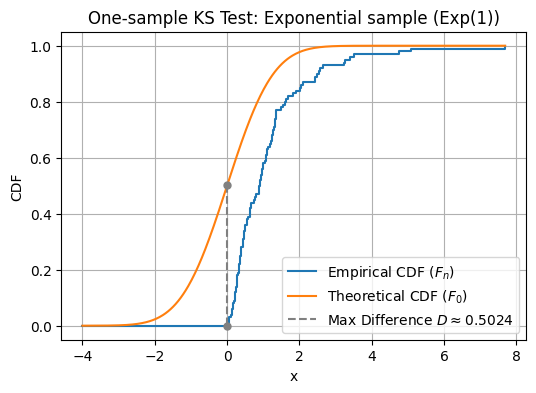

In [90]:
# Plot empirical CDF vs theoretical CDF and indicate D
x_grid = np.linspace(min(sample.min(), -4), max(sample.max(), 6), 500)
ecdf_vals = empirical_cdf(sample, x_grid)
theo_vals = std_normal_cdf(x_grid)

# compute point of maximum difference for plotting (fine grid approx)
grid_diffs = np.abs(ecdf_vals - theo_vals)
idx_max = np.argmax(grid_diffs)
x_max = x_grid[idx_max]
D_plot = grid_diffs[idx_max]

plt.figure(figsize=(6,4))

# Plot ECDF and Theoretical CDF
plt.step(x_grid, ecdf_vals, where='post', label='Empirical CDF ($F_n$)')
plt.plot(x_grid, theo_vals, label='Theoretical CDF ($F_0$)')

plt.vlines(x_max, theo_vals[idx_max], ecdf_vals[idx_max],
            color='gray',
            linestyles='dashed',
            zorder=5,
            label=f"Max Difference $D \\approx {D_plot:.4f}$")

plt.plot(x_max, theo_vals[idx_max], 'o', color='gray', markersize=5, zorder=6)
plt.plot(x_max, ecdf_vals[idx_max], 'o', color='gray', markersize=5, zorder=6)


plt.xlabel('x')
plt.ylabel('CDF')
plt.title(f"One-sample KS Test: {name}")

plt.legend()

plt.grid(True)
plt.show()

# SECTION B: TWO-SAMPLE KS TEST

Compare two independent samples: $\mathcal{N}(0.5, 2)$ vs $\mathcal{N}(1, 2)$.

**Note:** Here we deliberately generate random data each time the cell is run (without fixing the seed). The sd is chosen 2, so that sometimes we fail to reject $H_0$ even if the distributions aren't the same. Bigger sd means more "similar" this distributions will be.

## Run the test

Generate two sets of $n=100$ random samples.
* One from  $\mathcal{N}(0.5, 2)$.
* The other from $\mathcal{N}(1, 2)$.

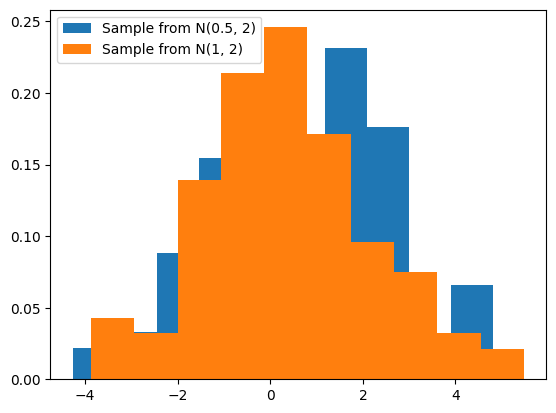

In [91]:
n = 100

sample1 = np.random.normal(loc=0.5, scale=2.0, size=n)  # N(0.5, 2)
sample2 = np.random.normal(loc=1.0, scale=2.0, size=n)     # N(1, 2)

plt.hist(sample1, density=True, label = "Sample from N(0.5, 2)")
plt.hist(sample2, density=True, label = "Sample from N(1, 2)")
plt.legend()
plt.show()

In [92]:
print("=== TWO-SAMPLE KS TEST (compare two empirical samples) ===\n")
n1, n2 = sample1.size, sample2.size
n_eff = n1 * n2 / (n1 + n2)
crit_value = get_critical_value(sig_level) / sqrt(n_eff)

print(f"Critical value: {crit_value}, Significance Level: {sig_level}")

if USE_SCIPY:
    D2, pval2 = stats.ks_2samp(sample1, sample2)
    print(f"SciPy ks_2samp results: D = {D2:.5f}, p-value = {pval2}")
else:
    D2, xloc, F1_at_x, F2_at_x = ks_statistic_twosample(sample1, sample2)
    pval2 = kolmogorov_pvalue_twosample(D2, n1, n2)
    print(f"Results: D = {D2:.5f}, approx. p-value = {pval2}")

print("_" * 50)
print(make_test_decision(D2, crit_value))



=== TWO-SAMPLE KS TEST (compare two empirical samples) ===

Critical value: 0.19206415147703973, Significance Level: 0.05
Results: D = 0.17000, approx. p-value = 0.11113334490733633
__________________________________________________
Fail to reject H0


## Visualize

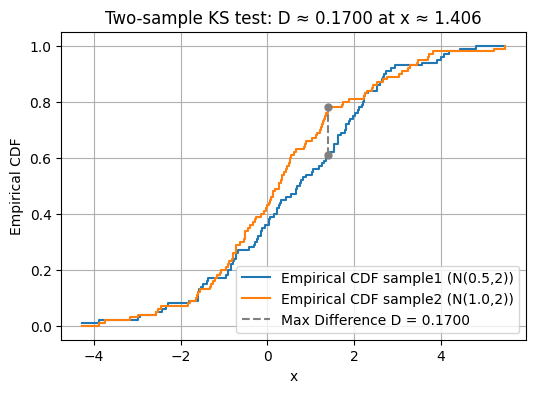

In [93]:
# Plot the two empirical CDFs and mark maximum difference
x_all = np.sort(np.concatenate((sample1, sample2)))
F1 = empirical_cdf(sample1, x_all)
F2 = empirical_cdf(sample2, x_all)
diffs = np.abs(F1 - F2)
idx = np.argmax(diffs)
x_star = x_all[idx]
D_star = diffs[idx]


plt.figure(figsize=(6,4))
plt.step(x_all, F1, where='post', label='Empirical CDF sample1 (N(0.5,2))')
plt.step(x_all, F2, where='post', label='Empirical CDF sample2 (N(1.0,2))')
plt.vlines(x_star, F1[idx], F2[idx], linestyles='dashed', label=f"Max Difference D = {D_star:.4f}", color="gray")


# Add dots at the endpoints of the D statistic segment for clarity
plt.plot(x_star, F1[idx], 'o', color='gray', markersize=5, zorder=6)
plt.plot(x_star, F2[idx], 'o', color='gray', markersize=5, zorder=6)


plt.xlabel('x')
plt.ylabel('Empirical CDF')
plt.title(f"Two-sample KS test: D ≈ {D_star:.4f} at x ≈ {x_star:.3f}")
plt.legend()
plt.grid(True)
plt.show()

# Summary



Here we collected all the cases covered in the notebook and the test results.

In [94]:
# Summary table of results
results = {
    "Test": ["One-sample KS (normal sample vs N(0,1))",
             "One-sample KS (exp sample vs N(0,1))",
             "Two-sample KS (N(0.5,2) vs N(1,2))"],
    "n": [n, n, f"{n1}, {n2}"],
}
crit_values = [
    get_critical_value(sig_level) / sqrt(n),
    get_critical_value(sig_level) / sqrt(n),
    get_critical_value(sig_level) / sqrt(n_eff)
    ]

if USE_SCIPY:
    results["D"] = [stats.kstest(sample_normal, 'norm')[0],
                    stats.kstest(sample_exp, 'norm')[0],
                    stats.ks_2samp(sample1, sample2)[0]]
    results["p-value"] = [stats.kstest(sample_normal, 'norm')[1],
                          stats.kstest(sample_exp, 'norm')[1],
                          stats.ks_2samp(sample1, sample2)[1]]
else:
    D1 = ks_statistic_onesample(sample_normal, std_normal_cdf)
    D1b = ks_statistic_onesample(sample_exp, std_normal_cdf)
    results["D"] = [D1, D1b, D_star]
    results["p-value"] = [kolmogorov_pvalue_onesample(D1, n),
                          kolmogorov_pvalue_onesample(D1b, n),
                          kolmogorov_pvalue_twosample(D_star, n1, n2)]
results["Decision"] = [make_test_decision(D_stat, crit_val) for D_stat, crit_val in zip([D1, D1b, D_star], crit_values)]

df_results = pd.DataFrame(results)
df_results

,Test,n,D,p-value,Decision
0,"One-sample KS (normal sample vs N(0,1))",100,0.115339,1.397606e-01,Fail to reject H0
1,"One-sample KS (exp sample vs N(0,1))",100,0.510337,4.777375e-23,Reject H0
2,"Two-sample KS (N(0.5,2) vs N(1,2))","100, 100",0.170000,1.111333e-01,Fail to reject H0
